# Building Ensemble Models:

In [1]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


### Classification - Based on Week 3

# 1. Import Data

In [2]:
df = pd.read_excel("C:\\Users\\mciniello\\Desktop\\Data Science Fundementals\\Data Mining and Advanced Analytics\\Class 3\\default of credit card clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# 2. Train/Test/Stack 
<font color=blue size=4>I'm not going to use a StratifiedSplit as I do not yet know which features are the most important. Perhaps I will retrain a model with a stratified training and test set once I understand the data a little better.

In [3]:
from sklearn.model_selection import train_test_split

df_train, df_test_stack = train_test_split(df, test_size=0.30, random_state=123)
df_test, df_stack = train_test_split(df_test_stack,test_size=0.5, random_state=123)

print(df_train.shape)
print(df_test.shape)
print(df_stack.shape)

(21000, 25)
(4500, 25)
(4500, 25)


# 3. Data Prep Pipeline

In [5]:
# Now let's build a pipeline for preprocessing the numerical attributes:

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from DataCleansing import CategoricalEncoder, DataFrameSelector #import saved custom functions

# set variable lists
feats_num = ['LIMIT_BAL','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 
            'PAY_5','PAY_6', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2',
            'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
feats_cat = ['SEX', 'EDUCATION', 'MARRIAGE']

# continuous variables
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(feats_num)),
        ('std_scaler', StandardScaler()),
    ])

# categorical variables
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(feats_cat)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

# join features
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

df_train_X = full_pipeline.fit_transform(df_train)
df_train_y = df_train['default payment next month'].copy()

print(df_train_X.shape)
print(df_train_y.shape)

(21000, 32)
(21000,)


C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
import sys
sys.modules.get(CategoricalEncoder.__module__)

<module 'DataCleansing' from 'C:\\Users\\mciniello\\AppData\\Local\\Continuum\\anaconda3\\lib\\DataCleansing.py'>

Custom file is saved in "DataCleansing' from 'C:\\Users\\mciniello\\AppData\\Local\\Continuum\\Anaconda3\\lib\\DataCleansing.py"


# 4. Select Error Metric and Build a Model

<font color=blue size=4>
I am going to use several error metrics and compare them. However the single metric I choose would depend on the business case.

- Conservative business case: Aim for high **Precision score** (the proportion of positive cases that were correctly identified), as you want to correctly identify as many risky loans as possible (even if it means you incorrectly clasify good loans).

- Risk seeking business case: Aim for **High Specifity** (the proportion of actual negative cases which are correctly identified) as you want to make sure you identify every good possible loan!

- Balanced business case: Aim for high **ROC AUC Score** as it provides a balanced score between the TPR and the FPR. 


#### Try out a single model to test the waters!

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
tree_clf = DecisionTreeClassifier(max_depth=10,
                                  min_samples_split=100,
                                 min_samples_leaf=100,
                                 max_leaf_nodes=50)
tree_clf.fit(df_train_X,df_train_y)
cross_val_score(tree_clf,
                df_train_X, df_train_y,
                n_jobs=-1,
                scoring='roc_auc',
                verbose=10)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished


array([ 0.7505582 ,  0.77231567,  0.76887727])

#### What does the tree look like?

In [68]:
print(len(df_train.EDUCATION.unique()))
print(len(df_train.SEX.unique()))
print(len(df_train.MARRIAGE.unique()))
print(len(feats_num))

7
2
4
19


In [69]:
FEAT_NAMES = ['LIMIT_BAL','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 
            'PAY_5','PAY_6', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
            'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2',
            'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','SEX:M','SEX:F', 
             'EDU:1','EDU:2','EDU:3','EDU:4','EDU:5','EDU:6','EDU:7', 
             'MARRIAGE:1','MARRIAGE:2','MARRIAGE:3','MARRIAGE:4']
print(len(FEAT_NAMES))

32


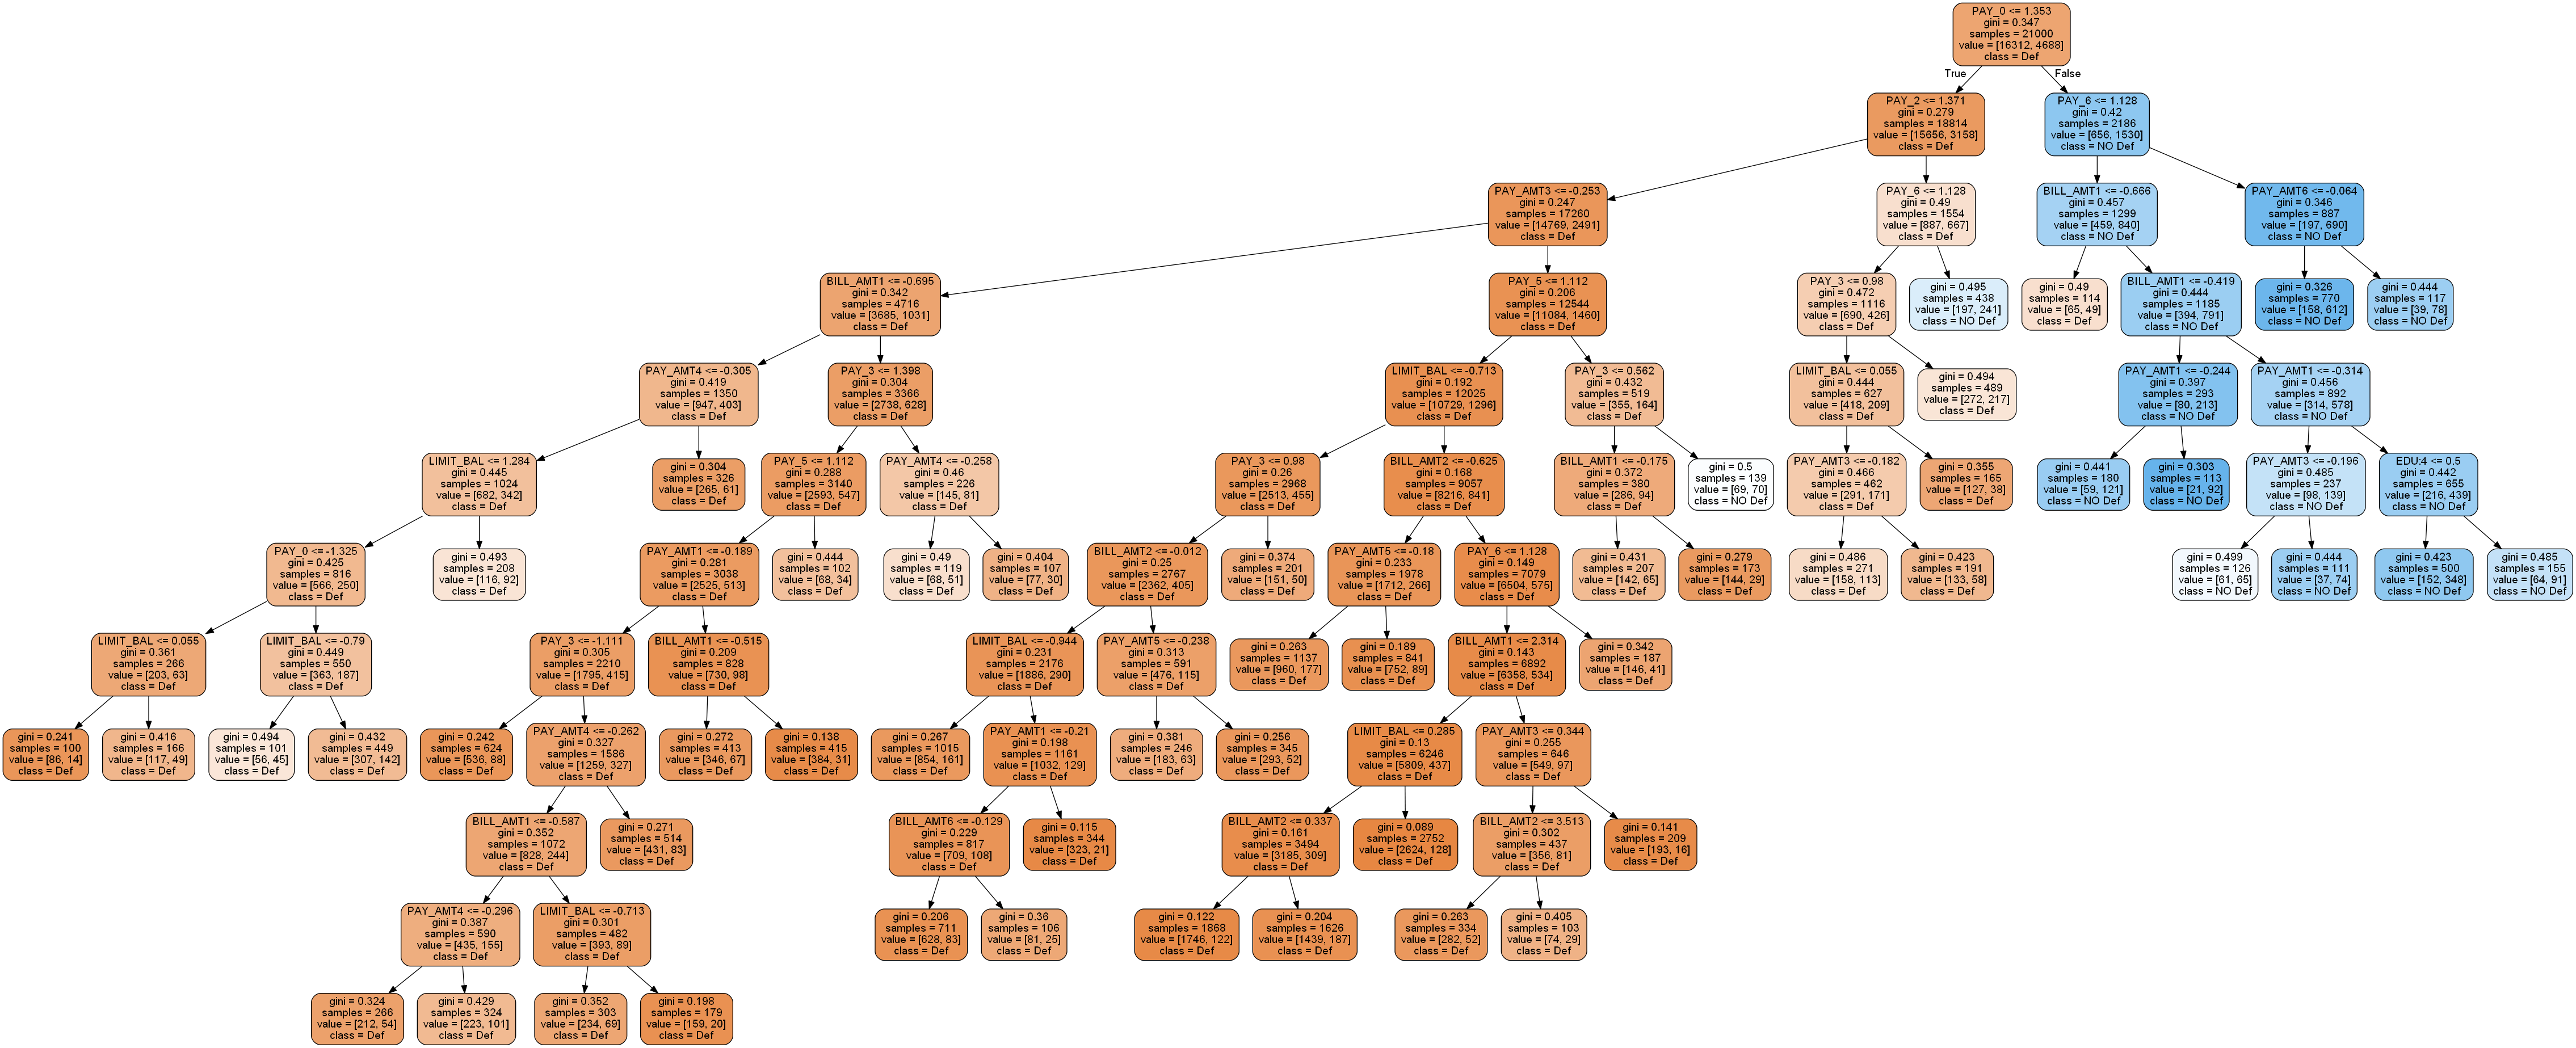

In [70]:
#Move paths to the correct location
import os
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

base = 'C:\\Users\\mciniello\\AppData\\Local\\Continuum\\Anaconda3\\envs\\py36\\'
def conda_fix(graph):
        path = os.path.join(base, "Library", "bin", "graphviz")
        paths = ("dot", "twopi", "neato", "circo", "fdp")
        paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
        graph.set_graphviz_executables(paths)


#create empty .dot file
dot_data = StringIO()

export_graphviz(
        tree_clf,
        out_file=dot_data,
        feature_names=FEAT_NAMES,
        class_names=['Def','NO Def'],
        rounded=True,
        filled=True,
    )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
conda_fix(graph)
Image(graph.create_png())

#### Run grid search to test multiple parameters

In [8]:
from sklearn.model_selection import GridSearchCV

params = [{'max_depth':[9,10,11,12],
          'min_samples_split':[92,93,94],
         'min_samples_leaf':[121,122,123],
         'max_leaf_nodes':[10,20,30,40]}]

tree_gs = GridSearchCV(tree_clf,
                       params,cv=3,
                       scoring='roc_auc',
                       n_jobs=-1,
                       verbose=2,
                       return_train_score=True)

tree_gs.fit(df_train_X,df_train_y)
print(tree_gs.best_score_)
tree_gs.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   49.2s finished


0.765693558223


{'max_depth': 9,
 'max_leaf_nodes': 40,
 'min_samples_leaf': 122,
 'min_samples_split': 93}

#### Finetune model with Randomized Grid Search

In [72]:
import numpy as np
from time import time
from operator import itemgetter
from scipy.stats import randint
from sklearn.grid_search import RandomizedSearchCV

# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters),'\n')
        print("")

# specify parameters and distributions to sample from
params = {"max_depth": randint(5, 15),
              "min_samples_split": randint(90, 100),
              "min_samples_leaf": randint(115, 125),
              "max_leaf_nodes": randint(30,60),
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 30

# construct model
tree_rand_gs = RandomizedSearchCV(tree_clf,
                                  params,
                                  cv=3,
                                  n_iter=n_iter_search,
                                  scoring='roc_auc',
                                  n_jobs=-1)

start = time()
tree_rand_gs.fit(df_train_X,df_train_y)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search),'\n')

report(tree_rand_gs.grid_scores_)

RandomizedSearchCV took 15.46 seconds for 30 candidates parameter settings. 

Model with rank: 1
Mean validation score: 0.766 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 13, 'max_leaf_nodes': 33, 'min_samples_leaf': 120, 'min_samples_split': 90} 


Model with rank: 2
Mean validation score: 0.766 (std: 0.004)
Parameters: {'criterion': 'entropy', 'max_depth': 12, 'max_leaf_nodes': 33, 'min_samples_leaf': 117, 'min_samples_split': 94} 


Model with rank: 3
Mean validation score: 0.766 (std: 0.010)
Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_leaf_nodes': 36, 'min_samples_leaf': 118, 'min_samples_split': 90} 




<font color=blue size=4> The model only improves slightly using RandomSearch, as the roc_auc seems to hover around 0.76. Lets run the model on the test data and see how it performs.</font>

In [73]:
from sklearn.metrics import accuracy_score # Correct/All instances
from sklearn.metrics import precision_score # (TP)/(TP+FP)
from sklearn.metrics import recall_score # (TP)/(TP+FN)
from sklearn.metrics import roc_auc_score # (TP)/(TP+FN)
from sklearn.metrics import roc_curve

def classy_scores(y,y_pred):
    print('Accuracy Score:', accuracy_score(y, y_pred))
    print('Precision Score:', precision_score(y, y_pred))
    print('Recall Score:', recall_score(y, y_pred))
    print('ROC_AUC Score:', roc_auc_score(y, y_pred))
    
df_test_X = full_pipeline.fit_transform(df_test)
df_test_y = df_test['default payment next month'].copy()

final_model = tree_rand_gs.best_estimator_
final_preds = final_model.predict(df_test_X)

classy_scores(df_test_y,final_preds)

Accuracy Score: 0.823555555556
Precision Score: 0.648881239243
Recall Score: 0.389865563599
ROC_AUC Score: 0.666062133625


C:\Users\mciniello\AppData\Local\Continuum\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# 5. Ensemble Learning

Make sure to read and understand the documentation for each classifier.

Remember to make your code modular; it will save you rewriting the same things multiple times and will help avoid copy paste errors.


  
- Tune the following classifiers:
  - Random forest classfier
  - Adaboost Tree classifier
  - Extra trees classifier
  - Gradient Boosted Tree classifier
  - Logistic Regression
  
- Analyze, compare, and interpret your results
- What ensemble yields the best result? Can you identify certain types of events that are classified better/worse from the type of algorithm?
- Is the feature importance consistent for all classifiers?

In [74]:
# Import all models
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

m1_RFC = RandomForestClassifier(random_state=123)
m2_ABC = AdaBoostClassifier(random_state=123)
m3_ETC = ExtraTreesClassifier(random_state=123)
m4_GBC = GradientBoostingClassifier(random_state=123)
m5_LRC = LogisticRegression(random_state=123)

### Build modules

In [75]:
import numpy as np
from time import time
from operator import itemgetter
from scipy.stats import randint
from sklearn.grid_search import RandomizedSearchCV
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from IPython.display import display


# ALL IN ONE
def GS_ALL(model, params, scoring='roc_auc', verbose=5, cv=3, X=df_train_X, y=df_train_y, n_top=3, label=None):
    # run model
    GS = GridSearchCV(model, params, cv=cv, scoring=scoring, n_jobs=-1, verbose=verbose, return_train_score=True)
    GS.fit(X,y)
   
    # show top models results
    results = pd.DataFrame(GS.cv_results_)
    display(results.sort_values(by='rank_test_score').set_index('rank_test_score')[0:n_top])
    
    # feature importances
    if model == m5_LRC:
        pass
    else:
        imp_feats = pd.DataFrame({'Features':FEAT_NAMES,
                                  'Importance':GS.best_estimator_.feature_importances_})
        display(imp_feats.sort_values('Importance',ascending=False)[0:10])

    # plot model
    y_probas = cross_val_predict(GS.best_estimator_, X, y, cv=3, method="predict_proba")
    y_scores_RF = y_probas[:, 1] 
    fpr, tpr, thresholds = roc_curve(y,y_scores_RF)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.title(model.__class__.__name__)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.show()
    return GS

### Random Forest Model

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   41.6s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,,,
1,1.586406,0.072800,0.777153,0.790179,10,23,119,91,50,"{'max_depth': 10, 'max_leaf_nodes': 23, 'min_s...",0.768613,0.795164,0.781739,0.786883,0.781107,0.788489,0.003211,0.007354,0.006044,0.003586
1,1.596742,0.065534,0.777153,0.790179,10,23,119,90,50,"{'max_depth': 10, 'max_leaf_nodes': 23, 'min_s...",0.768613,0.795164,0.781739,0.786883,0.781107,0.788489,0.032150,0.009171,0.006044,0.003586
1,1.608606,0.072800,0.777153,0.790179,10,23,119,89,50,"{'max_depth': 10, 'max_leaf_nodes': 23, 'min_s...",0.768613,0.795164,0.781739,0.786883,0.781107,0.788489,0.055521,0.014708,0.006044,0.003586


,Features,Importance
1,PAY_0,0.278037
2,PAY_2,0.176950
3,PAY_3,0.163539
4,PAY_4,0.082419
5,PAY_5,0.066930
6,PAY_6,0.056919
13,PAY_AMT1,0.048145
15,PAY_AMT3,0.018213
0,LIMIT_BAL,0.016850
14,PAY_AMT2,0.016485


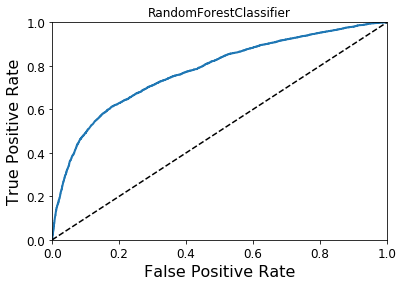

In [76]:
params = [{'max_depth':[10],
          'min_samples_split':[89,90,91],
         'min_samples_leaf':[119,120,121],
         'max_leaf_nodes':[21,22,23],
          'n_estimators':[50]}]
M1_RF = GS_ALL(m1_RFC,params,n_top=3,verbose=10)

### AdaBoost Classifier

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   53.4s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_n_estimators,params,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,
1,6.263415,0.244400,0.775437,0.787322,0.2,120,"{'learning_rate': 0.2, 'n_estimators': 120}",0.768520,0.792336,0.780122,0.783992,0.777672,0.785638,0.195392,0.007354,0.004993,0.003609
2,7.273919,0.228800,0.775396,0.789213,0.2,150,"{'learning_rate': 0.2, 'n_estimators': 150}",0.768777,0.793923,0.779824,0.786002,0.777588,0.787713,0.191626,0.026515,0.004769,0.003403
3,5.270279,0.207201,0.774651,0.785788,0.2,100,"{'learning_rate': 0.2, 'n_estimators': 100}",0.768312,0.790708,0.779037,0.782408,0.776603,0.784249,0.053974,0.002808,0.004591,0.003559


,Features,Importance
1,PAY_0,0.158333
0,LIMIT_BAL,0.100000
7,BILL_AMT1,0.100000
15,PAY_AMT3,0.066667
13,PAY_AMT1,0.066667
14,PAY_AMT2,0.058333
16,PAY_AMT4,0.058333
8,BILL_AMT2,0.050000
6,PAY_6,0.041667
9,BILL_AMT3,0.033333


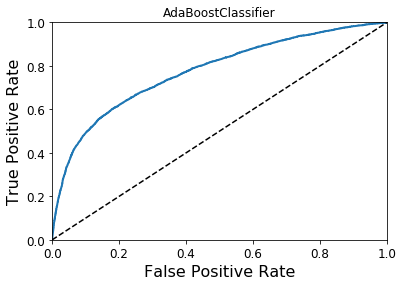

In [77]:
params = [{'learning_rate':[0.01,0.1,0.2],
           'n_estimators':[100,120,150]}]
M2_AB = GS_ALL(m2_ABC,params,n_top=3)

### ExtraTreesClassifier

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    7.3s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    7.6s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    8.4s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,
1,1.383002,0.1092,0.772127,0.798720,10,90,50,"{'max_depth': 10, 'min_samples_split': 90, 'n_...",0.763669,0.802186,0.777364,0.796250,0.775351,0.797723,0.155653,0.012737,0.006038,0.002524
2,1.147336,0.0701,0.771854,0.798431,10,91,50,"{'max_depth': 10, 'min_samples_split': 91, 'n_...",0.763344,0.801912,0.777076,0.795900,0.775144,0.797482,0.464350,0.007632,0.006070,0.002545
3,0.598834,0.0572,0.771588,0.798801,10,89,50,"{'max_depth': 10, 'min_samples_split': 89, 'n_...",0.762877,0.802405,0.777306,0.796111,0.774583,0.797886,0.006841,0.007354,0.006260,0.002649


,Features,Importance
1,PAY_0,0.227036
2,PAY_2,0.185332
5,PAY_5,0.152412
3,PAY_3,0.119146
4,PAY_4,0.107889
6,PAY_6,0.081612
0,LIMIT_BAL,0.034206
19,SEX:M,0.006428
14,PAY_AMT2,0.005991
17,PAY_AMT5,0.005581


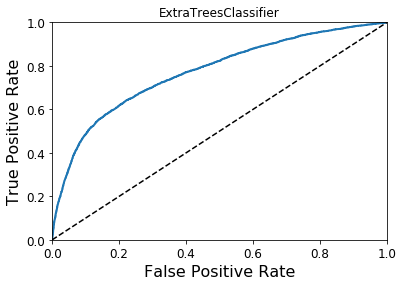

In [78]:
params = [{'max_depth':[10],
          'min_samples_split':[89,90,91],
          'n_estimators':[50]}]
M3_ET = GS_ALL(m3_ETC,params,n_top=3)

### GradientBoosting Classifier

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   48.8s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   56.7s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_n_estimators,params,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,
1,7.609053,0.029967,0.777999,0.815822,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.770168,0.818962,0.782311,0.812945,0.781519,0.815561,0.700327,0.001744,0.005547,0.002463
2,15.665797,0.047868,0.776524,0.838459,0.1,200,"{'learning_rate': 0.1, 'n_estimators': 200}",0.769442,0.840921,0.781351,0.836192,0.778782,0.838263,0.969239,0.001510,0.005117,0.001936
3,7.519099,0.015933,0.776385,0.827892,0.15,100,"{'learning_rate': 0.15, 'n_estimators': 100}",0.769233,0.831777,0.780959,0.825223,0.778963,0.826675,0.283178,0.000471,0.005122,0.002810


,Features,Importance
1,PAY_0,0.160712
7,BILL_AMT1,0.099821
0,LIMIT_BAL,0.073967
8,BILL_AMT2,0.062490
14,PAY_AMT2,0.051005
10,BILL_AMT4,0.047287
2,PAY_2,0.042382
6,PAY_6,0.041929
13,PAY_AMT1,0.039946
12,BILL_AMT6,0.039852


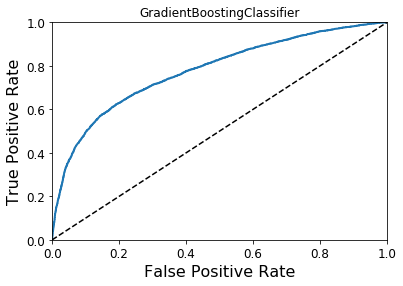

In [79]:
params = [{'learning_rate':[0.01,0.1,0.15],
           'n_estimators':[100,200]}]
M4_GB = GS_ALL(m4_GBC,params,n_top=3)

### Logistic Regression

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    6.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    6.6s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,
1,0.572468,0.000000,0.724009,0.726668,10,l2,"{'C': 10, 'penalty': 'l2'}",0.712311,0.732681,0.733229,0.722837,0.726488,0.724488,0.093103,0.000000,0.008718,0.004304
2,0.565768,0.006867,0.724000,0.726680,100,l2,"{'C': 100, 'penalty': 'l2'}",0.712235,0.732692,0.733265,0.722854,0.726501,0.724493,0.085642,0.006504,0.008766,0.004303
3,0.478868,0.000000,0.723950,0.726540,1,l2,"{'C': 1, 'penalty': 'l2'}",0.712458,0.732568,0.733114,0.722687,0.726280,0.724366,0.109954,0.000000,0.008593,0.004317


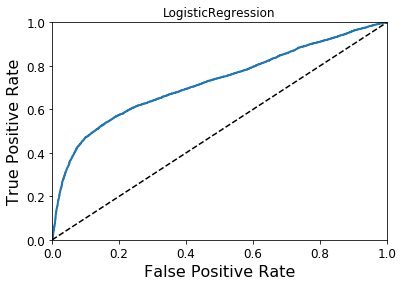

In [80]:
params = [{'penalty':['l2'],
          'C':[0.001,0.01,0.1,1,10,100]}] 
M5_LR = GS_ALL(m5_LRC,params,n_top=3)

### Voting classifier

In [81]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('RF', M1_RF.best_estimator_), ('AB', M2_AB.best_estimator_), ('ET', M3_ET.best_estimator_),('GB', M4_GB.best_estimator_),('LR', M5_LR.best_estimator_)],
                              voting='soft')

cross_val_score(voting_clf,
                df_train_X, df_train_y,
                n_jobs=-1,
                scoring='roc_auc',
                verbose=10)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   14.8s finished


array([ 0.76411514,  0.78045844,  0.78008822])

#### Testing the models!

In [82]:
# test the model
voting_clf.fit(df_train_X,df_train_y)

df_test_X = full_pipeline.fit_transform(df_test)
df_test_y = df_test['default payment next month'].copy()

models = [M1_RF.best_estimator_,
          M2_AB.best_estimator_,
          M3_ET.best_estimator_,
          M4_GB.best_estimator_,
          M5_LR.best_estimator_,
          voting_clf]

for clf in models:
    predictions = clf.predict(df_test_X)
    print(clf.__class__.__name__, roc_auc_score(df_test_y, predictions))

C:\Users\mciniello\AppData\Local\Continuum\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


RandomForestClassifier 0.619516357956
AdaBoostClassifier 0.64972335003
ExtraTreesClassifier 0.594855536995
GradientBoostingClassifier 0.663389884882
LogisticRegression 0.616289140856
VotingClassifier 0.625813609662


# 6. Model Stacking

In [83]:
#stack data and put them into a new_X data matrix
X0 = M1_RF.best_estimator_.predict_proba(df_train_X)[:,0]
X1 = M2_AB.best_estimator_.predict_proba(df_train_X)[:,0]
X2 = M3_ET.best_estimator_.predict_proba(df_train_X)[:,0]
X3 = M4_GB.best_estimator_.predict_proba(df_train_X)[:,0]
X4 = M5_LR.best_estimator_.predict_proba(df_train_X)[:,0]
new_train_X = pd.DataFrame({'X0':X0,'X1':X1,'X2':X2,'X3':X3,'X4':X4,}).as_matrix()

params = [{'max_depth':[10,11,12],
          'min_samples_split':[89,90,91],
         'min_samples_leaf':[119,120,121],
         'max_leaf_nodes':[21,22,23],
          'n_estimators':[50]}]
GS_stacked= GridSearchCV(m1_RFC, params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=10, return_train_score=True)
GS_stacked.fit(new_train_X,df_train_y)
   
# show top models results
results = pd.DataFrame(GS.cv_results_)
display(results.sort_values(by='rank_test_score').set_index('rank_test_score')[0:5])

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Paralle

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
rank_test_score,,,,,,,,,,,,,,,,,,,,
1,1.401773,0.066001,0.809713,0.8213,10,23,119,90,50,"{'max_depth': 10, 'max_leaf_nodes': 23, 'min_s...",0.802367,0.825297,0.814871,0.818293,0.811903,0.820311,0.042436,0.005021,0.005334,0.002944
1,1.399137,0.062400,0.809713,0.8213,11,23,119,89,50,"{'max_depth': 11, 'max_leaf_nodes': 23, 'min_s...",0.802367,0.825297,0.814871,0.818293,0.811903,0.820311,0.027364,0.000000,0.005334,0.002944
1,1.411506,0.064067,0.809713,0.8213,10,23,119,91,50,"{'max_depth': 10, 'max_leaf_nodes': 23, 'min_s...",0.802367,0.825297,0.814871,0.818293,0.811903,0.820311,0.050291,0.010761,0.005334,0.002944
1,1.380071,0.055567,0.809713,0.8213,10,23,119,89,50,"{'max_depth': 10, 'max_leaf_nodes': 23, 'min_s...",0.802367,0.825297,0.814871,0.818293,0.811903,0.820311,0.006901,0.006514,0.005334,0.002944
1,1.391972,0.062400,0.809713,0.8213,12,23,119,91,50,"{'max_depth': 12, 'max_leaf_nodes': 23, 'min_s...",0.802367,0.825297,0.814871,0.818293,0.811903,0.820311,0.037099,0.000000,0.005334,0.002944


#### Testing the model

In [84]:
#stack data and put them into a new_X data matrix
df_stack_X = full_pipeline.fit_transform(df_stack)
df_stack_y = df_stack['default payment next month'].copy()

X0 = M1_RF.best_estimator_.predict_proba(df_stack_X)[:,0]
X1 = M2_AB.best_estimator_.predict_proba(df_stack_X)[:,0]
X2 = M3_ET.best_estimator_.predict_proba(df_stack_X)[:,0]
X3 = M4_GB.best_estimator_.predict_proba(df_stack_X)[:,0]
X4 = M5_LR.best_estimator_.predict_proba(df_stack_X)[:,0]
new_test_X = pd.DataFrame({'X0':X0,'X1':X1,'X2':X2,'X3':X3,'X4':X4,}).as_matrix()

predictions = GS_stacked.best_estimator_.predict(new_test_X)
roc_auc_score(df_stack_y, predictions)

C:\Users\mciniello\AppData\Local\Continuum\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.65413313310964594

# 7. Conclusions:

***Ensemble Methods:*** All of the individual models seem to perform similarily well, hovering around a 75-76% validation roc_auc score. Additionally most of the models seem to predict pay0-pay4 as the most important features. However the Boosting models produce pay0 as the top feature, but Pay_Amnt 1-4 as the next most important features. This is probably due to the different weightings AdaBoost and GradientBoost use to update the model, which could skew the importance of certain features. 

***Stacking:*** Very interesting! The stack model actually produced the highest validation roc_auc scores. Moving forward with this, I would probably first try to fine tune the individual models a little more, then I would try to incorporate a bunch of additional models into the first layer (this is starting to feel like a neural network actually!). Then I would probably build a module to automate this whole process. 

***Model Testing:*** Whats strang is that, all models undeperformed on test holdouts, even when compared to the validation tests. This may mean that I need to perform some StratifiedShuffleSplit when creating my train, test, and stack sets, in order to ensure that each set has the appropriate percentage of key features. 

**Q. (Optional) If a Decision Tree is overfitting the training set, is it a good idea to try decreasing max_depth?**

Yes, this will help to regularize the model and probabably increase model bias, but reduce variance (decreasing your training score but improving your validation and test scores).

**Q. (Optional) If a Decision Tree is underfitting the training set, is it a good idea to try scaling the input features?**

Probably not, as DecisionTrees tend to be indifferent to feature scales (I think...). A better idea would be to remove some of the regularization parameters (min/max samples and nodes, for instance)

**Q. (Optional) What is the difference between hard and soft voting classifiers?**

Hard voting is majority rule voting, whereas soft voting predicts the class label based on the argmax of the sums of the predicted probabilities.

**Q. (Optional) If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?**

If AdaBoost is overfitting the model, you should try reducing the number of estimators or more strongly regularizing the base estimator (the default is a DecisionTree model). That said, if AdaBoost is underfitting the data, it would make sense to reduce regularization of the base estimator, or increase the number of estimators. 

**Q. (Optional) If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?**

The learning rate in a Gradient Boosting model scales the contribution of each tree. So if you set it to a low value like 0.1 you will need more trees in the ensemble to fit the training set (otherwise the model may UNDERfit the data). That said, reducing the learning would help the model generalize better and reduce overfitting. 